This work is licensed under CC BY-SA 4.0. To view a copy of this license, visit http://creativecommons.org/licenses/by-sa/4.0/

In [58]:
import sqlite3 as sl
#from sklearn.neighbors import KernelDensity
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
import random

In [59]:
# Code taken from: https://gist.github.com/tillahoffmann/f844bce2ec264c1c8cb5
# https://stackoverflow.com/questions/27623919/weighted-gaussian-kernel-density-estimation-in-python
# http://nbviewer.ipython.org/gist/tillahoffmann/f844bce2ec264c1c8cb5
from six import string_types
class custom_gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [60]:
dbfile = './web-application/database.db'
# Create a SQL connection to our SQLite database
con = sl.connect(dbfile)

# creating cursor
cur = con.cursor()
# reading all table names
#table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
#print(table_list)

# Be sure to close the connection
# con.close()

In [61]:
userIds = [a[0] for a in cur.execute("SELECT * FROM clicks")]
timestamps = [a[1] for a in cur.execute("SELECT * FROM clicks")]
presses = [a for a in cur.execute("SELECT * FROM clicks")]
# datetime.strptime(timestamps[0], "%Y-%m-%dT%H:%M:%S.%fZ")
playbacks = [a for a in cur.execute("SELECT * FROM playbacks")]
print(userIds)
print(timestamps)
print(playbacks)
con.close()


['b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503',

In [62]:
datetime_objects = np.array([datetime.datetime.strptime(a, "%Y-%m-%dT%H:%M:%S.%fZ") for a in timestamps])
# Convert datetime objects to numerical values (e.g., timestamps)
numeric_values = np.array([dt.timestamp() for dt in datetime_objects])
datetimed_presses = []
for t in presses:
    datetimed_presses.append((t[0], datetime.datetime.strptime(t[1], "%Y-%m-%dT%H:%M:%S.%fZ")))
print(datetimed_presses)
datetimed_playbacks = []
for t in playbacks:
    datetimed_playbacks.append((t[0], datetime.datetime.strptime(t[1], "%Y-%m-%dT%H:%M:%S.%fZ")))
print(datetimed_playbacks)

[('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 22, 4, 810000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 22, 25, 99000)), ('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 22, 43, 84000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 13, 337000)), ('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 23, 11, 759000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 13, 408000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 16, 59000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 15, 552000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 21, 583000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 21, 387000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024

In [63]:
last_playback = datetimed_playbacks[-1]

ids = []
for push in datetimed_presses:
    time = push[1]
    if time > last_playback[1]:
        ids.append(push[0])

uniqueIds = np.unique(np.array(ids))

print(uniqueIds)

['88296048-7cb3-4d6f-b8af-9a3c2d404b5b']


In [64]:
# periodised_playbacks
# cleaned_presses

individual_pools = []
for person in uniqueIds:
    individual_pool = []
    for click in datetimed_presses:
        if (click[1] > last_playback[1] and click[0] == person):
            individual_pool.append(click[1])
    individual_pools.append((person, individual_pool))




for person in individual_pools:
    if len(person[1]) > 0:
        print(person[0])
        #print(person[0] + ": " + str(len(person[1])))
        for click in person[1]:
            print(click)


88296048-7cb3-4d6f-b8af-9a3c2d404b5b
2024-03-14 17:28:30.459000
2024-03-14 17:28:31.788000
2024-03-14 17:28:31.945000
2024-03-14 17:28:32.131000
2024-03-14 17:28:33.179000
2024-03-14 17:28:33.302000
2024-03-14 17:28:33.416000
2024-03-14 17:28:33.529000
2024-03-14 17:28:33.659000
2024-03-14 17:28:33.783000
2024-03-14 17:28:33.892000
2024-03-14 17:28:34.016000
2024-03-14 17:28:34.114000
2024-03-14 17:28:34.353000
2024-03-14 17:28:34.602000
2024-03-14 17:28:35.121000
2024-03-14 17:28:35.243000
2024-03-14 17:28:35.374000
2024-03-14 17:28:35.493000
2024-03-14 17:28:35.608000
2024-03-14 17:28:35.731000
2024-03-14 17:28:35.869000
2024-03-14 17:28:35.979000
2024-03-14 17:28:36.093000
2024-03-14 17:28:36.194000
2024-03-14 17:28:36.438000
2024-03-14 17:28:36.659000
2024-03-14 17:28:36.878000


In [65]:
# Varying kernel size using different bw_method values
bw_methods = [0.1]  # Different bandwidths

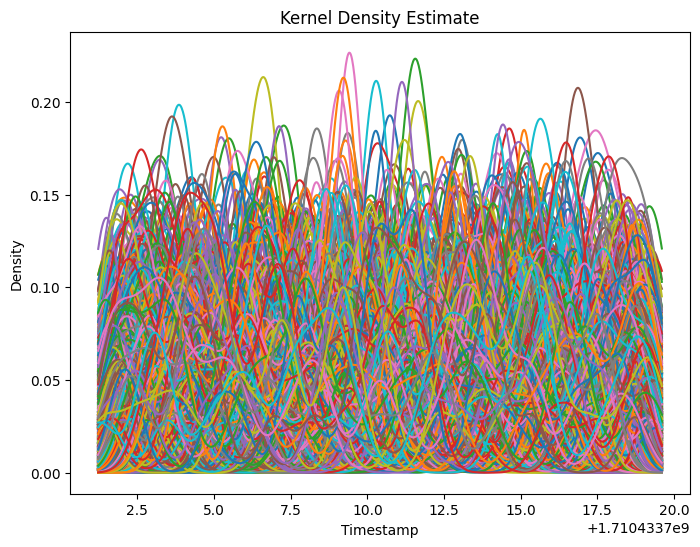

In [66]:
# Random plot counts
N = 1000



clip_duration = (datetime.datetime.now() - last_playback[1]).total_seconds()




plt.figure(figsize=(8, 6))

for i in range(N):
    
    random_pool = np.zeros(0)
    weights = np.zeros(0)
    
    for individual in individual_pools:
        
        random_numeric_values = [last_playback[1].timestamp() + (random.random() * clip_duration) for _ in range(len(individual[1]))]
        random_pool = np.concatenate((random_pool, random_numeric_values))

        individual_weights = [1/len(individual[1]) for dt in individual[1]]
        
        individual_weights = np.array(individual_weights)
        
        weights = np.concatenate((weights, individual_weights))

    if len(random_pool) == 0:
        continue
    
    # Set up the range of values for which to estimate the density
    x_values = np.linspace(last_playback[1].timestamp(), (last_playback[1].timestamp() + clip_duration), 1000)
    

    

    for bw_method in bw_methods:
        kde = custom_gaussian_kde(dataset=random_pool, weights=weights, bw_method=bw_method)
        density_estimate = kde.evaluate(x_values)
        plt.plot(x_values, density_estimate, label=f'bw_method={bw_method}')


plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Kernel Density Estimate')

plt.show()
plt.close()

Duration: 20.20717
Start time: 1710433701.222
Final pool:
[ 9.23700023 10.56600022 10.72300005 10.90900016 11.95700002 12.08000016
 12.19400001 12.30700016 12.43700004 12.56100011 12.67000008 12.79400015
 12.8920002  13.13100004 13.38000011 13.89900017 14.02100015 14.15200019
 14.27100015 14.38600016 14.50900006 14.64700007 14.75700021 14.87100005
 14.97200012 15.21600008 15.43700004 15.65600014]
Weights:
[0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
Random pool:
[ 4.58562985 13.33119125  6.97823554 14.94511091  3.06867562 15.00824051
 16.80200725 10.80715332  8.41711449  2.66946209 14.62134097 12.78352403
 19.92033905  7.7747275   3.62647694  3.52833024  8.38452633 16.88895206
  5.18748075  0.08257778  6.8933832  11.60563

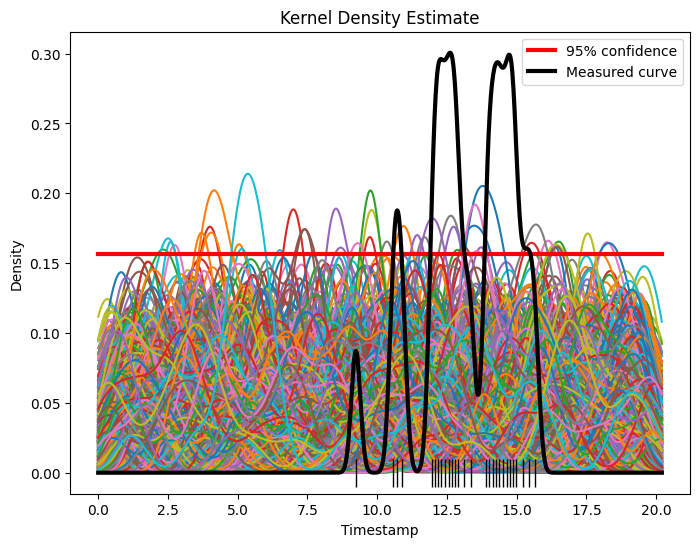

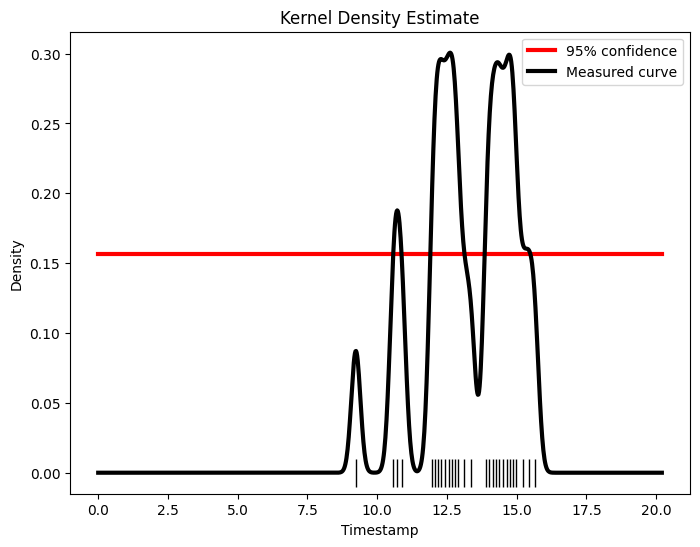

In [67]:
# Random plot counts
N = 1000

confidence_threshold = 0.95

start_time = last_playback[1].timestamp()
clip_duration = (datetime.datetime.now() - last_playback[1]).total_seconds()

print("Duration: " + str(clip_duration))
print("Start time: " + str(start_time))

# Set up the range of values for which to estimate the density
x_values = np.linspace(0, clip_duration, 1000)
#x_values = np.linspace(clip[2][1].timestamp(), clip[2][2].timestamp(), 1000)


final_pool = np.zeros(0)
weights = np.zeros(0)

for individual in individual_pools:
    
    individual_numeric_values = [(click.timestamp() - start_time) for click in individual[1]]
    
    individual_weights = [1/len(individual[1]) for click in individual[1]]
    
    individual_numeric_values = np.array(individual_numeric_values)
    individual_weights = np.array(individual_weights)
    
    final_pool = np.concatenate((final_pool, individual_numeric_values))
    weights = np.concatenate((weights, individual_weights))


print("Final pool:")
print(final_pool)
print("Weights:")
print(weights)


plt.figure(figsize=(8, 6))

maxes = []

for i in range(N):
    
    random_pool = np.zeros(0)
    random_weights = np.zeros(0)

    for individual in individual_pools:
        
        random_numeric_values = [random.random() * clip_duration for _ in range(len(individual[1]))]
        random_numeric_values = np.array(random_numeric_values)
        random_pool = np.concatenate((random_pool, random_numeric_values))

        individual_weights = [1/len(individual[1]) for dt in individual[1]]
        
        individual_weights = np.array(individual_weights)
        
        random_weights = np.concatenate((random_weights, individual_weights))
    
    
    print("Random pool:")
    print(random_pool)
    print("Random weights:")
    print(random_weights)

    
    for bw_method in bw_methods:
        kde = custom_gaussian_kde(dataset=random_pool, weights=random_weights, bw_method=bw_method)
        density_estimate = kde.evaluate(x_values)
        maxes.append(max(density_estimate))
        plt.plot(x_values, density_estimate)


# Calculate the relevance threshold
maxes.sort()
print("Maxes:")
print(maxes)
percentile_index = int(len(maxes) * confidence_threshold)
confident_maxes = maxes[:percentile_index]
print("Confident maxes:")
print(confident_maxes)
confidence_line = max(confident_maxes)

plt.plot(x_values, np.repeat(confidence_line, len(x_values)), label='95% confidence', linewidth=3, color='red')


# Plot the individual curve

for bw_method in bw_methods:
    kde = custom_gaussian_kde(dataset=final_pool, weights=weights, bw_method=bw_method)
    density_estimate = kde.evaluate(x_values)
    plt.plot(x_values, density_estimate, label='Measured curve', linewidth=3, color='black')
    # Rug plot
    plt.plot(final_pool, [0.0]*len(final_pool), '|', color='k', markersize="20")


plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Kernel Density Estimate')
#plt.title('Kernel Density Estimate validity threshold calculation example')
plt.legend()

plt.show()
plt.close()

plt.figure(figsize=(8, 6))

plt.plot(x_values, np.repeat(confidence_line, len(x_values)), label='95% confidence', linewidth=3, color='red')


# Plot the individual curve

for bw_method in bw_methods:
    kde = custom_gaussian_kde(dataset=final_pool, weights=weights, bw_method=bw_method)
    density_estimate = kde.evaluate(x_values)
    plt.plot(x_values, density_estimate, label='Measured curve', linewidth=3, color='black')
    # Rug plot
    plt.plot(final_pool, [0.0]*len(final_pool), '|', color='k', markersize="20")


plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Kernel Density Estimate')
#plt.title('Kernel Density Estimate validity threshold calculation example')
plt.legend()

plt.show()
plt.close()